## 1. Import Packages

In [1]:
# !pip list
# !pip install --upgrade scikit-learn
# !pip install --upgrade imbalanced-learn
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
import imblearn;print("imblearn",imblearn.__version__)

Linux-3.10.0-693.2.2.el7.x86_64-x86_64-with-centos-7.4.1708-Core

Python 3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 

[GCC 7.2.0]

NumPy 1.19.4

SciPy 1.1.0

Scikit-Learn 0.24.2

imblearn 0.8.1


In [2]:
!pip install scikit-learn sklearn imblearn --user

Looking in indexes: https://mirrors.aliyun.com/pypi/simple










In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import Sequential, utils, regularizers, Model, Input
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout, AvgPool1D
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

## 2. Data loading and Preprocessing

In [4]:
# 加载训练集和测试集
train = pd.read_csv('train.csv')
test  = pd.read_csv('testA.csv')
print(train.shape, test.shape)
print(train.isnull().sum(), test.isnull().sum())
print(train.info(),test.info())
print(train.describe(),test.describe())

(100000, 3) (20000, 2)

id                   0

heartbeat_signals    0

label                0

dtype: int64 id                   0

heartbeat_signals    0

dtype: int64

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Data columns (total 3 columns):

 #   Column             Non-Null Count   Dtype  

---  ------             --------------   -----  

 0   id                 100000 non-null  int64  

 1   heartbeat_signals  100000 non-null  object 

 2   label              100000 non-null  float64

dtypes: float64(1), int64(1), object(1)

memory usage: 2.3+ MB

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 20000 entries, 0 to 19999

Data columns (total 2 columns):

 #   Column             Non-Null Count  Dtype 

---  ------             --------------  ----- 

 0   id                 20000 non-null  int64 

 1   heartbeat_signals  20000 non-null  object

dtypes: int64(1), object(1)

memory usage: 312.6+ KB

None None

                  id          label

In [5]:
train.head().append(train.tail())

,id,heartbeat_signals,label
0,0,"0.9912297987616655,0.9435330436439665,0.764677...",0.0
1,1,"0.9714822034884503,0.9289687459588268,0.572932...",0.0
2,2,"1.0,0.9591487564065292,0.7013782792997189,0.23...",2.0
3,3,"0.9757952826275774,0.9340884687738161,0.659636...",0.0
4,4,"0.0,0.055816398940721094,0.26129357194994196,0...",2.0
99995,99995,"1.0,0.677705342021188,0.22239242747868546,0.25...",0.0
99996,99996,"0.9268571578157265,0.9063471198026871,0.636993...",2.0
99997,99997,"0.9258351628306013,0.5873839035878395,0.633226...",3.0
99998,99998,"1.0,0.9947621698382489,0.8297017704865509,0.45...",2.0
99999,99999,"0.9259994004527861,0.916476635326053,0.4042900...",0.0


In [6]:
test.head()

,id,heartbeat_signals
0,100000,"0.9915713654170097,1.0,0.6318163407681274,0.13..."
1,100001,"0.6075533139615096,0.5417083883163654,0.340694..."
2,100002,"0.9752726292239277,0.6710965234906665,0.686758..."
3,100003,"0.9956348033996116,0.9170249621481004,0.521096..."
4,100004,"1.0,0.8879490481178918,0.745564725322326,0.531..."


In [7]:
# 数据精度量化压缩
def reduce_mem_usage(df):
    # 处理前 数据集总内存计算
    start_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    # 遍历特征列
    for col in df.columns:
        # 当前特征类型
        col_type = df[col].dtype
        # 处理 numeric 型数据
        if col_type != object:
            c_min = df[col].min()  # 最小值
            c_max = df[col].max()  # 最大值
            # int 型数据 精度转换
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # float 型数据 精度转换
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # 处理 object 型数据
        else:
            df[col] = df[col].astype('category')  # object 转 category
    
    # 处理后 数据集总内存计算
    end_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
# 训练集特征处理与精度量化
train_list = []
for items in train.values:
    train_list.append([items[0]] + [float(i) for i in items[1].split(',')] + [items[2]])
train = pd.DataFrame(np.array(train_list))
train.columns = ['id'] + ['s_' + str(i) for i in range(len(train_list[0])-2)] + ['label']  # 特征分离
train = reduce_mem_usage(train)  # 精度量化


# 测试集特征处理与精度量化
test_list=[]
for items in test.values:
    test_list.append([items[0]] + [float(i) for i in items[1].split(',')])
test = pd.DataFrame(np.array(test_list))
test.columns = ['id'] + ['s_'+str(i) for i in range(len(test_list[0])-1)]  # 特征分离
test = reduce_mem_usage(test)  # 精度量化

Memory usage of dataframe is 157.93 MB

Memory usage after optimization is: 39.67 MB

Decreased by 74.9%

Memory usage of dataframe is 31.43 MB

Memory usage after optimization is: 7.90 MB

Decreased by 74.9%


In [9]:
train.head()

,id,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204,label
0,0.0,0.991211,0.943359,0.764648,0.618652,0.379639,0.190796,0.040222,0.026001,0.031708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.971680,0.929199,0.572754,0.178467,0.122986,0.132324,0.094421,0.089600,0.030487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.000000,0.958984,0.701172,0.231812,0.000000,0.080688,0.128418,0.187500,0.280762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3.0,0.975586,0.934082,0.659668,0.249878,0.237061,0.281494,0.249878,0.249878,0.241455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.000000,0.055817,0.261230,0.359863,0.433105,0.453613,0.499023,0.542969,0.616699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [10]:
test.head()

,id,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_195,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204
0,100000.0,0.991699,1.000000,0.631836,0.136230,0.041412,0.102722,0.120850,0.123413,0.107910,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,100001.0,0.607422,0.541504,0.340576,0.000000,0.090698,0.164917,0.195068,0.168823,0.198853,...,0.389893,0.386963,0.367188,0.364014,0.360596,0.357178,0.350586,0.350586,0.350586,0.36377
2,100002.0,0.975098,0.670898,0.686523,0.708496,0.718750,0.716797,0.720703,0.701660,0.596680,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,100003.0,0.995605,0.916992,0.520996,0.000000,0.221802,0.404053,0.490479,0.527344,0.518066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,100004.0,1.000000,0.888184,0.745605,0.531738,0.380371,0.224609,0.091125,0.057648,0.003914,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [11]:
# 查看训练集, 分离标签与样本, 去除 id
y_train = train['label']
x_train = train.drop(['id', 'label'], axis=1)
print(f"train: {x_train.shape}, {y_train.shape}")

# 查看测试集, 去除 id
X_test = test.drop(['id'], axis=1)
print(f"test: {X_test.shape}")

train: (100000, 205), (100000,)

test: (20000, 205)


## 3. Data Analysis

### 3.1 Basic analysis

In [12]:
train.describe()

,id,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204,label
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.0,100000.0,100000.000000,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
mean,49999.500000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN
std,28867.658203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,24999.750000,0.913086,0.694824,0.346436,0.096191,0.129883,0.134521,0.112183,0.101013,0.100586,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,49999.500000,0.984375,0.859375,0.548828,0.282471,0.238037,0.245850,0.226562,0.233765,0.235352,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,74999.250000,1.000000,0.933105,0.685547,0.519531,0.431396,0.443115,0.450439,0.432373,0.396484,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0
max,99999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,0.983887,1.0,1.0,1.0,1.0,1.0,1.0,3.0


In [13]:
test.describe()

,id,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_195,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,109999.500000,0.872559,0.772461,0.514648,0.323242,0.301270,0.303955,0.292725,0.281738,0.270996,...,0.008499,0.007965,0.007450,0.007214,0.006939,0.006599,0.006386,0.005981,0.005295,0.005150
std,5773.646973,0.263916,0.237549,0.241699,0.256592,0.226685,0.215088,0.218262,0.212036,0.200073,...,0.061371,0.059784,0.058044,0.056641,0.056061,0.054382,0.053833,0.051910,0.048462,0.047272
min,100000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,104999.750000,0.910645,0.690918,0.341003,0.097336,0.129272,0.134155,0.111816,0.101379,0.100403,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,109999.500000,0.983887,0.857422,0.545410,0.279785,0.237305,0.247437,0.227722,0.233765,0.236694,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,114999.250000,1.000000,0.932617,0.683105,0.515137,0.429199,0.443848,0.451904,0.436523,0.401123,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,119999.000000,1.000000,1.000000,1.000000,0.998535,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.978516,1.000000,1.000000,1.000000,0.990234,0.999023,0.843262


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 100000 entries, 0 to 99999

Columns: 207 entries, id to label

dtypes: float16(206), float32(1)

memory usage: 39.7 MB


In [15]:
train.dtypes

id       float32
s_0      float16
s_1      float16
s_2      float16
s_3      float16
          ...   
s_201    float16
s_202    float16
s_203    float16
s_204    float16
label    float16
Length: 207, dtype: object

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 20000 entries, 0 to 19999

Columns: 206 entries, id to s_204

dtypes: float16(205), float32(1)

memory usage: 7.9 MB


In [17]:
train.isnull().sum()
# train.isnull().sum()[train.isnull().sum() != 0]

id       0
s_0      0
s_1      0
s_2      0
s_3      0
        ..
s_201    0
s_202    0
s_203    0
s_204    0
label    0
Length: 207, dtype: int64

In [18]:
test.isnull().sum()

id       0
s_0      0
s_1      0
s_2      0
s_3      0
        ..
s_200    0
s_201    0
s_202    0
s_203    0
s_204    0
Length: 206, dtype: int64

In [19]:
train['label']

0        0.0
1        0.0
2        2.0
3        0.0
4        2.0
        ... 
99995    0.0
99996    2.0
99997    3.0
99998    2.0
99999    0.0
Name: label, Length: 100000, dtype: float16

In [20]:
train['label'].value_counts()

0.0    64327
3.0    17912
2.0    14199
1.0     3562
Name: label, dtype: int64

In [21]:
x_train.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_195,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204
0,0.991211,0.943359,0.764648,0.618652,0.379639,0.190796,0.040222,0.026001,0.031708,0.065552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.971680,0.929199,0.572754,0.178467,0.122986,0.132324,0.094421,0.089600,0.030487,0.040497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.958984,0.701172,0.231812,0.000000,0.080688,0.128418,0.187500,0.280762,0.328369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.975586,0.934082,0.659668,0.249878,0.237061,0.281494,0.249878,0.249878,0.241455,0.230713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.055817,0.261230,0.359863,0.433105,0.453613,0.499023,0.542969,0.616699,0.676758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_test.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_195,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204
0,0.991699,1.000000,0.631836,0.136230,0.041412,0.102722,0.120850,0.123413,0.107910,0.110535,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.607422,0.541504,0.340576,0.000000,0.090698,0.164917,0.195068,0.168823,0.198853,0.153564,...,0.389893,0.386963,0.367188,0.364014,0.360596,0.357178,0.350586,0.350586,0.350586,0.36377
2,0.975098,0.670898,0.686523,0.708496,0.718750,0.716797,0.720703,0.701660,0.596680,0.487061,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.995605,0.916992,0.520996,0.000000,0.221802,0.404053,0.490479,0.527344,0.518066,0.545410,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,1.000000,0.888184,0.745605,0.531738,0.380371,0.224609,0.091125,0.057648,0.003914,0.007820,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


### 3.2 Exploratory Data Analysis

**Visual category distribution**

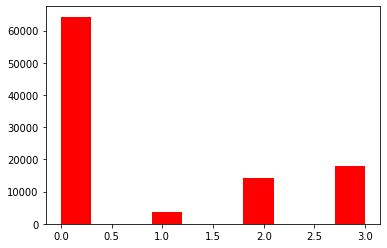

In [23]:
plt.hist(train['label'], orientation = 'vertical', histtype = 'bar', color = 'red')
plt.show() 

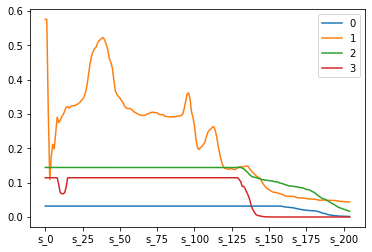

In [24]:
# 可视化每个类别的均值
np.mean(x_train[y_train==0]).T.plot(label='0')
np.mean(x_train[y_train==1]).T.plot(label='1')
np.mean(x_train[y_train==2]).T.plot(label='2')
np.mean(x_train[y_train==3]).T.plot(label='3')
plt.legend()

**Class imbalance problem**

after smote, k_x_train.shape: (257308, 205), k_y_train.shape: (257308,)


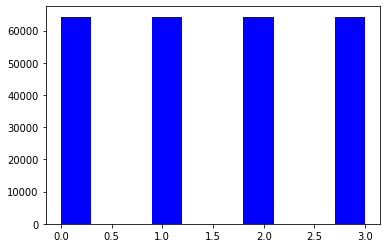

In [28]:
# # 使用 SMOTE 对数据进行上采样以解决类别不平衡问题
smote = SMOTE(random_state=422)
k_x_train, k_y_train = smote.fit_resample(x_train, y_train)  
k_x_train, k_y_train = SMOTE().fit_resample(x_train, y_train) 
print(f"after smote, k_x_train.shape: {k_x_train.shape}, k_y_train.shape: {k_y_train.shape}")
plt.hist(k_y_train, orientation = 'vertical', histtype = 'bar', color = 'blue')
plt.show() 

## 4. 评估函数

In [26]:
# 评估函数
def abs_sum(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    loss = sum(sum(abs(y_pred-y_true)))
    return loss